# Purpose

Reshape the cluster output data so that we can have a CSV file that is easy to share and use for QA with multiple people.

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import logging
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow

import omegaconf
from omegaconf import OmegaConf
from subclu.utils.hydra_config_loader import LoadHydraConfig

import subclu
from subclu.data.data_loaders import LoadSubreddits, LoadPosts
from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.language_code_mapping import (
    L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL,
    D_CLD3_CODE_TO_LANGUAGE_NAME,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)

# ---
from tqdm.auto import tqdm
from subclu.data.counterpart_loaders import (
    LoadCounterpartSeeds,
    combine_reshaped_seeds
)


print_lib_versions([np, pd, plotly, sns, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.2


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Load config
Use Hydra configs to make it easier to replicate the run.

Copy the config to the model folder so it's easier to trace it back

In [4]:
config_clustering_v032a = LoadHydraConfig(
    config_name='cluster_output',
    config_path="../config",
    overrides=[
        f"data_text_and_metadata=top_subreddits_2021_07_16",
        f"data_embeddings_to_cluster=top_subs-2021_07_16-use_multi_lower_case_false_00",
        f"data_cluster_outputs=top_subreddits_v0.3.2a",
    ],
)
config_seeds = LoadHydraConfig(
    config_name='seed_counterparts_germany_2021-08-17',
    config_path="../config/data_subreddit_counterparts",
)

# pprint(config_clustering_v032a.config_dict, indent=2)
pprint(config_seeds.config_dict)

{'bucket_name': 'i18n-subreddit-clustering',
 'dataset_name': 'German subreddit seeds for counterparts',
 'f_seeds1': 'Criteria for default subs - [OLD]default '
             'subs-2021-08-13_15-17.csv',
 'f_seeds2': 'Criteria for default subs - [final] '
             'autosub+counterpart-2021-08-18.csv',
 'f_skiprows1': 3,
 'f_skiprows2': 1,
 'folder_data_prefix': 'data/subreddit_counterparts'}


In [5]:
# Extract CLUSTERING keys into easier to call
d_embeddings = config_clustering_v032a.config_dict['data_embeddings_to_cluster']
d_conf_meta = config_clustering_v032a.config_dict['data_text_and_metadata']
d_clusters = config_clustering_v032a.config_dict['data_cluster_outputs']

# embedding data
run_uuid = d_embeddings['run_uuid']

f_embeddings_sub_level = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc']
f_embeddings_post_level = d_embeddings['df_post_level_agg_c_post_comments_sub_desc']

f_sub_distance_c = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity']
f_sub_dist_pair_c = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair']

l_ix_sub = d_embeddings['l_ix_sub']  # 'subreddit_id',  b/c of dask's multi-index, I'm only using name
l_ix_post = d_embeddings['l_ix_post']

# cluster output data
bucket_and_folder_prefix = f"gs://{d_clusters['bucket_name']}/{d_clusters['folder_model_outputs']}"
f_subs_c_cluster_labels = d_clusters['f_subs_agg_c_cluster_labels']
f_subs_c_similarity_pair = d_clusters['f_subs_agg_c_similarity_pair']
col_best_clusters_a = d_clusters['col_best_clusters_a']

# Load German geo-relevant & Ambassador subreddits

Need to export them from BigQuery first (sigh).

Use them to create flags to make it easier to find counterparts.

In [6]:
config_geo_relevant = LoadHydraConfig(
    config_name='geo_relevant_subs_2021-08-18',
    config_path="../config/data_geo_relevant_subreddits",
)
config_ambassador = LoadHydraConfig(
    config_name='de_ambassador_subs_2021-08-18',
    config_path="../config/data_ambassador_subreddits",
)

In [7]:
%%time

df_geo = pd.read_parquet(
    f"gs://{config_geo_relevant.config_dict['bucket_name']}/"
    f"{config_geo_relevant.config_dict['folder_data_prefix']}/"
)
print(df_geo.shape)

(8115, 6)
CPU times: user 247 ms, sys: 31.2 ms, total: 278 ms
Wall time: 1.46 s


In [8]:
%%time

df_ambassador = pd.read_parquet(
    f"gs://{config_ambassador.config_dict['bucket_name']}/"
    f"{config_ambassador.config_dict['folder_data_prefix']}/"
)
print(df_ambassador.shape)

(171, 3)
CPU times: user 12.5 ms, sys: 6.46 ms, total: 18.9 ms
Wall time: 574 ms


# Load Distances & Clusters (cluster IDs)

These should be the same files that feed the bigquery tables:
- `reddit-employee-datasets.david_bermejo.subclu_subreddit_distance_v0032_c_posts_and_comments_and_meta`
- `reddit-employee-datasets.david_bermejo.subclu_subreddit_cluster_labels_v032_a`


In [9]:
print(bucket_and_folder_prefix)
print(f_subs_c_cluster_labels)
print(f_subs_c_similarity_pair)
print(col_best_clusters_a)

gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45
df_subs_only-meta_and_multiple_clustering_algos-2021-08-13_022453-3767_by_58.parquet
df_sub_level_agg_c_similarity_pair-2021-08-13_021828-14186522_by_18.parquet
cluster_id_agg_ward_cosine_200


In [13]:
# !gsutil ls -r $bucket_clusters
# !gsutil ls $bucket_and_folder_prefix

In [14]:
%%time
df_subs_cluster = pd.read_parquet(f"{bucket_and_folder_prefix}/{f_subs_c_cluster_labels}")

print(df_subs_cluster.shape)

(3767, 58)
CPU times: user 87.8 ms, sys: 19.3 ms, total: 107 ms
Wall time: 950 ms


In [15]:
%%time
# this one will take a while (over 15 seconds) because it's over 14 million rows...
df_subs_distance = pd.read_parquet(f"{bucket_and_folder_prefix}/{f_subs_c_similarity_pair}")

print(df_subs_distance.shape)

(14186522, 18)
CPU times: user 13 s, sys: 2.5 s, total: 15.5 s
Wall time: 8.23 s


In [17]:
df_subs_cluster[[c for c in df_subs_cluster.columns if 'description' not in c]].iloc[:6, :14]

,subreddit_name,cluster_id_agg_ward_cosine_200,subreddit_title,rating,topic,over_18,subreddit_language,primary_post_language,primary_post_language_percent,primary_post_type,primary_post_type_percent,posts_for_modeling_count,post_median_word_count,primary_post_language_in_use_multilingual
0,natureismetal,0,Nature is Metal,pg13,None,f,en,English,0.918333,image,0.566667,1200,9.0,True
1,ape,0,ape,not_shown_in_theaters,None,f,en,English,0.569423,image,0.329173,641,5.0,True
2,flyfishing,0,flyfishing,g,None,f,en,English,0.940833,image,0.495000,1200,9.0,True
3,birding,0,a place for birders to be,pg13,None,f,en,English,0.917500,image,0.653333,1200,8.0,True
4,bassfishing,0,Bass Fishing at its Finest,pg,None,f,en,English,0.920833,image,0.437500,1200,12.0,True
5,beach,0,Welcome to Beach Reddit!,pg,None,f,en,English,0.715789,link,0.463158,475,6.0,True


In [16]:
df_subs_distance.iloc[:6, :14]

,cosine_distance,subreddit_name_a,subreddit_name_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,post_median_word_count_b,post_median_word_count_a,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,subreddit_id_a
0,0.719657,1071,tamamahbapengelli,None,None,Turkish,0.677419,4.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
1,0.708699,1071,nonakanal,None,None,German,0.712589,6.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
2,0.706756,1071,okemakkermaloot,None,None,Dutch,0.358974,3.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
3,0.706363,1071,kudurdum,None,None,Turkish,0.544170,7.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
4,0.698231,1071,okbrudimongo,r,Internet Culture and Memes,German,0.651042,4.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
5,0.695058,1071,playboicartihentai,None,None,English,0.592391,5.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q


# Export cluster data to CSV so that it's easy to edit and share

Need to have a central place to do QA.

Columns to make data easier to work with/useful:
- add column with geo-relevant column
- add column to show whether a subreddit is an ambassador sub

- add column to subreddit URL
- add column to subreddit URL with google translate
- add a flag for clusters that have at least 1 German (or Ambassador) subreddit
    - so we can filter down to just DE clusters (DE <> DE, DE <> EN)
    
- new col: related clusters
    - for all clusters, find distance between the two biggest subreddits in each cluster & show closest groups
    - need to think through what this actually means in practice. But the idea is: i should be able to see related clusters close together so it's easy to re-assign clusters if they fit better in an adjacent subreddit.

(in spreadsheets):
- translate the subreddit name
- translate the subreddit description


In [18]:
# columns used for new-cols & aggregations
col_manual_topic = 'manual_topic_and_rating'
col_ger_subs_count = 'german_subs_in_cluster'
col_ger_or_ambassador = 'german_or_ambassador_sub'
col_cluster_users_l28_sum = 'users_l28_for_cluster'
col_cluster_primary_topics = 'primary_topics_in_cluster'

l_cluster_cols_for_qa = [
    'cluster_id_agg_ward_cosine_200',
    'subreddit_name',
    'subreddit_id',
    'subreddit_title',
    'subreddit_public_description',
    
    'over_18',
    'rating',
    'topic',
    'rating_version',
    'topic_version',
    'subreddit_language',
    'primary_post_language',
    'primary_post_language_percent',
    'English_posts_percent',
    'German_posts_percent',
    
    'primary_post_type',
    'primary_post_type_percent',
    'posts_for_modeling_count',
    'post_median_word_count',
    
    'subscribers',
    'users_l28',
    'posts_l28',
    'comments_l28',
    
    'image_post_type_percent',
    'text_post_type_percent',
    'link_post_type_percent',
    
    # hide these in spreadsheet
    'mlflow_aggregation_run_uuid',
    col_manual_topic,
    'pt',
    
]

l_cluster_cols_for_qa_front = [
    'cluster_id_agg_ward_cosine_200',
    col_ger_subs_count,
    col_cluster_primary_topics,
    'subreddit_name',
    'subreddit_id',
    'subreddit_title',
    'subreddit_public_description',
    
    'subreddit_url',
    'subreddit_url_with_google_translate',
    col_ger_or_ambassador,
    'geo_country_code',
    'ambassador_sub',
]
df_subs_cluster_qa = (
    df_subs_cluster[l_cluster_cols_for_qa].copy()
    .merge(
        df_geo[['subreddit_name', 'geo_country_code']],
        how='left',
        on='subreddit_name'
    )
    
)

# Add columns to flag DE & ambassador subs
df_subs_cluster_qa['ambassador_sub'] = np.where(
    df_subs_cluster_qa['subreddit_name'].isin(df_ambassador['subreddit_name']),
    'yes',
    'no',
)
df_subs_cluster_qa[col_ger_or_ambassador] = np.where(
    (
        (df_subs_cluster_qa['ambassador_sub'] == 'yes') |
        (df_subs_cluster_qa['geo_country_code'] == 'DE')
    ),
    'yes',
    'no',
)


# Add sub URLs
df_subs_cluster_qa['subreddit_url'] = 'https://www.reddit.com/r/' + df_subs_cluster_qa['subreddit_name']
df_subs_cluster_qa['subreddit_url_with_google_translate'] = (
    'https://translate.google.com/translate?hl=&sl=auto&tl=en&u=' + 
    df_subs_cluster_qa['subreddit_url']
)


# count of German subs per cluster
df_german_subs_per_cluster = (
    df_subs_cluster_qa[df_subs_cluster_qa[col_ger_or_ambassador] == 'yes'].groupby([col_best_clusters_a])
    .agg(
        **{col_ger_subs_count: ('subreddit_name', 'nunique'),}
    )
)
df_subs_cluster_qa = df_subs_cluster_qa.merge(
    df_german_subs_per_cluster.reset_index(),
    how='left',
    on=col_best_clusters_a,
)
df_subs_cluster_qa[col_ger_subs_count] = df_subs_cluster_qa[col_ger_subs_count].fillna(0).astype(int)


# Sum users_28 in cluster to help prioritize big clusters first
# This could back-fire if the first subreddits are too broad... might drop it if it doesn't help
df_cluster_aggs = (
    df_subs_cluster_qa.groupby([col_best_clusters_a], as_index=False)
    .agg(
        **{col_cluster_users_l28_sum: ('users_l28', 'sum'),}
    )
)
df_subs_cluster_qa = df_subs_cluster_qa.merge(
    df_cluster_aggs,
    how='left',
    on=col_best_clusters_a,
)


# ========================
# get primary topics per cluster
# ===
df_clusters_primary_topics = (
    df_subs_cluster_qa.groupby([col_best_clusters_a, col_manual_topic], as_index=False)
    .agg(
        subreddit_count=('subreddit_name', 'nunique')
    )
)
# Set the `uncategorized` labels to negative and sort by subreddit_count so it always shows up last
df_clusters_primary_topics['subreddit_count'] = np.where(
    df_clusters_primary_topics[col_manual_topic] == 'uncategorized', 
    -df_clusters_primary_topics['subreddit_count'],
    df_clusters_primary_topics['subreddit_count']
)
df_clusters_primary_topics = (
    df_clusters_primary_topics
    .sort_values(by=[col_best_clusters_a, 'subreddit_count'], ascending=False)
)
# df_clusters_primary_topics.head()

# convert from rows to a list of topics
df_clusters_primary_topics = (
    df_clusters_primary_topics
    .groupby(col_best_clusters_a, as_index=True)[col_manual_topic]
    .apply(list)
    .to_frame()
    .reset_index()
)
# Remove python's list-related characters from output
df_clusters_primary_topics[col_manual_topic] = (
    df_clusters_primary_topics[col_manual_topic].astype(str)
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace("'", '', regex=False)
    .str.replace('"', '', regex=False)
)
df_clusters_primary_topics = df_clusters_primary_topics.rename(columns={col_manual_topic: col_cluster_primary_topics})
# Merge new column back to QA df
df_subs_cluster_qa = df_subs_cluster_qa.merge(
    df_clusters_primary_topics,
    how='left',
    on=col_best_clusters_a,
)


# sort rows to make QA easier
df_subs_cluster_qa = (
    df_subs_cluster_qa
    .sort_values(
        by=[col_cluster_primary_topics, col_ger_subs_count, col_cluster_users_l28_sum, col_best_clusters_a, col_ger_or_ambassador, 'users_l28'],
        ascending=[False, False, False, True, False, False], 
    )
    .reset_index(drop=True)
)


# Reorganize column order
df_subs_cluster_qa = df_subs_cluster_qa[reorder_array(l_cluster_cols_for_qa_front, df_subs_cluster_qa.columns)]
print(df_subs_cluster_qa.shape)

(3768, 37)


In [19]:
for clust_ in tqdm(list(df_subs_cluster_qa[col_best_clusters_a].unique())[:3]):
    mask_cluster = df_subs_cluster_qa[col_best_clusters_a] == clust_
    if df_subs_cluster_qa[mask_cluster][col_ger_subs_count].values[0] > 0:
        display(
            style_df_numeric(
                df_subs_cluster_qa[mask_cluster].drop(['subreddit_public_description'], axis=1).iloc[:10, :16]
            )
        )

  0%|          | 0/3 [00:00<?, ?it/s]

,cluster_id_agg_ward_cosine_200,german_subs_in_cluster,primary_topics_in_cluster,subreddit_name,subreddit_id,subreddit_title,subreddit_url,subreddit_url_with_google_translate,german_or_ambassador_sub,geo_country_code,ambassador_sub,over_18,rating,topic,rating_version,topic_version
29,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",asozialesnetzwerk,t5_392ha,AN Sektion Reddit,https://www.reddit.com/r/asozialesnetzwerk,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/asozialesnetzwerk,yes,DE,no,None,None,None,None,None
30,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",dachschaden,t5_irnzx,DACHschaden,https://www.reddit.com/r/dachschaden,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/dachschaden,yes,DE,no,f,r,"Culture, Race, and Ethnicity",v2,v3
31,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",coronavirusdach,t5_2gqps0,CoronavirusDACH,https://www.reddit.com/r/coronavirusdach,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/coronavirusdach,yes,DE,no,None,pg,World News,None,v3
32,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",afdwatch,t5_3g4p3,AfD Watch,https://www.reddit.com/r/afdwatch,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/afdwatch,yes,DE,no,None,r,None,v2,None
33,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",pozilei,t5_jd3zt,"Böse Pozilei, Keine Krapfen!",https://www.reddit.com/r/pozilei,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/pozilei,yes,DE,no,f,None,None,None,None
34,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",afd,t5_2ri5p,Alternative fürs Denken,https://www.reddit.com/r/afd,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/afd,yes,DE,no,None,None,None,None,None
35,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",afdkritisiertafd,t5_i8jrb,"Kommt rein, aber putzt Euch vorher die Schuhe ab",https://www.reddit.com/r/afdkritisiertafd,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/afdkritisiertafd,yes,DE,no,f,None,None,None,None
36,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",volksverpetzer,t5_w375w,Volksverpetzer,https://www.reddit.com/r/volksverpetzer,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/volksverpetzer,yes,DE,no,f,pg,None,v1,None
37,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",diepartei,t5_2yrcq,"Partei für Arbeit, Rechtsstaat, Tierschutz, Elitenförderung und basisdemokratische Initiative",https://www.reddit.com/r/diepartei,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/diepartei,yes,DE,no,None,None,None,None,None
38,86,17,"world news, culture, race, and ethnicity, funny/humor, uncategorized",nachrichten,t5_2vk0m,Nachrichten,https://www.reddit.com/r/nachrichten,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/nachrichten,yes,DE,no,None,pg,World News,v2,v3


# Create new aggregate/summary df to use as the key for cluster-level labels

In [ ]:
TODO

In [160]:
col_total_subs_count = 'subreddits_in_cluster_count'
col_ger_subs_count_redo = 'german_subreddits_in_cluster_count'
col_ger_subs_pct = 'german_subreddits_in_cluster_percent'

# Create base query with counts
df_cluster_level_qa = (
    df_subs_cluster_qa.groupby([col_best_clusters_a], as_index=False)
    .agg(
        **{col_total_subs_count: ('subreddit_name', 'nunique'),}
    )
).merge(
    df_german_subs_per_cluster,
    how='left',
    on=col_best_clusters_a,
).rename(columns={col_ger_subs_count: col_ger_subs_count_redo})

df_cluster_level_qa[col_ger_subs_count_redo] = (
    df_cluster_level_qa[col_ger_subs_count_redo].fillna(0)
).astype(int)

# get % of German subs in cluster
df_cluster_level_qa[col_ger_subs_pct] = (
    df_cluster_level_qa[col_ger_subs_count_redo] /
    df_cluster_level_qa[col_total_subs_count]
)

# Add primary topics
df_cluster_level_qa = df_cluster_level_qa.merge(
    df_clusters_primary_topics,
    how='left',
    on=col_best_clusters_a,
)


# TODO(djb): instead of only the top subreddit, maybe pick the top 3
#. it's hard to see a pattern when we only look at one subreddit
# append top German sub for each cluster
#  it assumes that subs-qa has already been sorted
mask_ger_or_amb_subs = df_subs_cluster_qa[col_ger_or_ambassador] == 'yes'

# df_cluster_level_qa = df_cluster_level_qa.merge(
#     df_subs_cluster_qa[mask_ger_or_amb_subs]
#     .drop_duplicates(subset=[col_best_clusters_a,], keep='first')
#     [[col_best_clusters_a, 'subreddit_name', ]],
#     how='left',
#     on=col_best_clusters_a,
# ).rename(columns={'subreddit_name': 'top_german_subreddit'})

# df_cluster_level_qa = df_cluster_level_qa.merge(
#     df_subs_cluster_qa[~mask_ger_or_amb_subs]
#     .drop_duplicates(subset=[col_best_clusters_a,], keep='first')
#     [[col_best_clusters_a, 'subreddit_name', ]],
#     how='left',
#     on=col_best_clusters_a,
# ).rename(columns={'subreddit_name': 'top_non_german_subreddit'})


# sort values
df_cluster_level_qa = df_cluster_level_qa.sort_values(
    by=[col_ger_subs_count_redo, col_total_subs_count],
    ascending=False
)

df_cluster_level_qa.shape

(200, 5)

In [161]:
df_clusters_top_subs = (
    df_subs_cluster_qa[mask_ger_or_amb_subs]
    .groupby(col_best_clusters_a, as_index=True)['subreddit_name']
    .apply(list)
    .to_frame()
    .reset_index()
).rename(columns={'subreddit_name': 'top_german_subreddits'})

df_clusters_top_subs = df_clusters_top_subs.merge(
    df_subs_cluster_qa[~mask_ger_or_amb_subs]
    .groupby(col_best_clusters_a, as_index=True)['subreddit_name']
    .apply(list)
    .to_frame()
    .reset_index()
    .rename(columns={'subreddit_name': 'top_non_german_subreddits'}),
    how='outer',
    on=col_best_clusters_a,
)

# Remove python's list-related characters from output
for c_ in ['top_german_subreddits', 'top_non_german_subreddits']:
    df_clusters_top_subs[c_] = (
        df_clusters_top_subs[c_]
        .str[:6]
        .astype(str)
        .str.replace('[', '', regex=False)
        .str.replace(']', '', regex=False)
        .str.replace("'", '', regex=False)
        .str.replace('"', '', regex=False)
    )

# Merge back with df-QA
df_cluster_level_qa = df_cluster_level_qa.merge(
    df_clusters_top_subs,
    how='left',
    on=col_best_clusters_a,
)

df_cluster_level_qa.shape

(200, 7)

In [162]:
# does it make sense to remove uncategorized??
# df_cluster_level_qa[col_cluster_primary_topics] = (
#     df_cluster_level_qa[col_cluster_primary_topics].str.replace(", uncategorized", '')
# )

In [166]:
style_df_numeric(df_cluster_level_qa.head(10), rename_cols_for_display=True)

,cluster id agg ward cosine 200,subreddits in cluster count,german subreddits in cluster count,german subreddits in cluster percent,primary topics in cluster,top german subreddits,top non german subreddits
0,11,73,52,71.23%,"over18_nsfw, podcasts and streamers, uncategorized","shirindavid, denisemski, nika_irani, sonnyloops, nonakanal, heidiklum","rubirose, socialmilf, caomi02, anna_shumate, neekolul, r34"
1,91,54,46,85.19%,"over18_nsfw, uncategorized","nicoledobrikovof, katjakrasavicenudes, germanonlyfans, laramarieconrads, marisolyotta, nikairani","katianakay, megnuttleaked, alliecatt3, niamhflinter, alliyah, lilwaifulia"
2,14,47,40,85.11%,"over18_nsfw, internet culture and memes, uncategorized","wixbros, loredanahot, deutschepornos, deutschetributes, annaschmidt, gaygermany","kudurdum, viennagonewild, dickpics, sissymaids, feetonface, sub"
3,74,56,39,69.64%,"internet culture and memes, funny/humor, place/culture, podcasts and streamers, uncategorized","wasletztepreis, spacefrogs, 600euro, okbrudimongo, ichbin40undlustig, reved","nhaa, okmatewanker, porramauricio, cellbits, buenzli, wismichu"
4,127,44,38,86.36%,"place/culture, uncategorized","berlin, munich, hamburg, frankfurt, stuttgart, cologne","montreal, paris, wien, graz, linz, innsbruck"
5,23,51,36,70.59%,"over18_nsfw, celebrity, uncategorized","palinarojinski, nikasofieactive, lisakueppers, mrsbella, alinamour_hot, emiliabte","tiktokthots, woesenpai69, esterexposito, africanbootymeat, instaboldreels, sophiafone"
6,138,31,23,74.19%,"over18_nsfw, uncategorized","elisaalinenudes, eyfreundin, lucycat, nicolekopchak, ramona_jst, vanessamainew","chloe, anittaonlyfans, nsfw_chick_of, mikailadance, abigalemandlerfans, racheldelgado"
7,177,24,19,79.17%,"over18_nsfw, uncategorized","germansgonewild, annitheduck, marialoeffler, bibisbeautypalacensfw, juliabeautx_xxx, emmyruss","amihot, babyfacejass, himynameisalliyah, mollyeskamshit, hotornot"
8,86,19,17,89.47%,"world news, culture, race, and ethnicity, funny/humor, uncategorized","asozialesnetzwerk, dachschaden, coronavirusdach, afdwatch, pozilei, afd","nichtdietagespresse, satire_de_en"
9,25,33,15,45.45%,"over18_nsfw, celebrity, uncategorized","germanpornstuff, nicolemariejeannmj, katjakrasavicefans, katharina_kkr, annyaurora, carmengeiss","enamorandonos, girls, mileycyrus, eroticfemdom, shakira, celebgroupjerk"


In [168]:
style_df_numeric(df_cluster_level_qa.tail(10), rename_cols_for_display=True)

,cluster id agg ward cosine 200,subreddits in cluster count,german subreddits in cluster count,german subreddits in cluster percent,primary topics in cluster,top german subreddits,top non german subreddits
190,154,6,0,0.00%,uncategorized,nan,"doordash, starbucks, doordash_drivers, grubhubdrivers, sherwinwilliams, retail"
191,188,6,0,0.00%,"over18_nsfw, uncategorized",nan,"sexyhair, instababez, brickhousebabes, quadsandglutes, racksandabs, golfchicks"
192,196,6,0,0.00%,"medical and mental health, religion and spirituality, uncategorized",nan,"glasses, sunglasses, eyes, eyetriage, contacts, aurareadings"
193,140,5,0,0.00%,uncategorized,nan,"pokemon, pokemongobrag, spoofertrades, themedgyms, pokemonplatinum"
194,149,5,0,0.00%,uncategorized,nan,"theeprincessnatalie, pornvideosonlyfans, brandi_sheri, ladalyumos, oliveashly"
195,194,5,0,0.00%,uncategorized,nan,"solar, energy, nuclear, solarenergy, wind"
196,146,4,0,0.00%,uncategorized,nan,"karma, upvote, karmawhore, needkarma"
197,179,4,0,0.00%,uncategorized,nan,"vaxxhappened, vaccinesideeffects, conspiro, unvaccinated"
198,197,4,0,0.00%,"beauty and makeup, over18_nsfw, uncategorized",nan,"beards, shorthairedhotties, longhair, braids"
199,183,3,0,0.00%,"religion and spirituality, uncategorized",nan,"astrology, vedicastrology, zodiacsigns"


# Load counterpart seeds & create col to flag them

nvm. might need to do as a separate tab in the spreadsheet

# Save df to GCS so we can convert it into a spreadsheet

In [169]:
print(bucket_and_folder_prefix)
print(f_subs_c_cluster_labels)
print(f_subs_c_similarity_pair)
print(col_best_clusters_a)

gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45
df_subs_only-meta_and_multiple_clustering_algos-2021-08-13_022453-3767_by_58.parquet
df_sub_level_agg_c_similarity_pair-2021-08-13_021828-14186522_by_18.parquet
cluster_id_agg_ward_cosine_200


In [ ]:
BREAK

## Save cluster-level df

In [170]:
shape_ = df_cluster_level_qa.shape
df_cluster_level_qa.to_csv(
    (
        f"{bucket_and_folder_prefix}/df_subs_only-cluster_level_pivot_for_qa"
        f"-{datetime.utcnow().strftime('%Y-%m-%d_%H%M')}"
        f"-{shape_[0]}_by_{shape_[1]}.csv"
    ),
    index=False
)

## Save subreddit-level df

In [ ]:
BREAK

In [185]:
shape_ = df_subs_cluster_qa.shape
df_subs_cluster_qa.to_csv(
    (
        f"{bucket_and_folder_prefix}/df_subs_only-meta_and_clustering_for_qa"
        f"-{datetime.utcnow().strftime('%Y-%m-%d_%H%M')}"
        f"-{shape_[0]}_by_{shape_[1]}.csv"
    ),
    index=False
)

In [175]:
# style_df_numeric(df_subs_cluster_qa.head())

## Only 99 subreddits have a German/Ambassador subreddit
So that should help us cut down on QA time a lot

In [89]:
df_german_subs_per_cluster[col_ger_subs_count].describe()

count    99.000000
mean      5.929293
std      10.218283
min       1.000000
25%       1.000000
50%       2.000000
75%       5.500000
max      52.000000
Name: german_subs_in_cluster, dtype: float64

In [91]:
df_german_subs_per_cluster.sort_values(by=col_ger_subs_count, ascending=False).head()

,german_subs_in_cluster
cluster_id_agg_ward_cosine_200,
11,52
91,46
14,40
74,39
127,38


In [86]:
df_subs_cluster_qa.drop_duplicates(subset=col_best_clusters_a)[col_ger_subs_count].describe()

count    200.000000
mean       2.935000
std        7.762218
min        0.000000
25%        0.000000
50%        0.000000
75%        1.250000
max       52.000000
Name: german_subs_in_cluster, dtype: float64

In [92]:
value_counts_and_pcts(
    df_subs_cluster_qa.drop_duplicates(subset=col_best_clusters_a),
    [col_ger_subs_count],
    sort_index=True,
    top_n=15,
)

,count,percent,cumulative_percent
german_subs_in_cluster,,,
0,101,50.5%,50.5%
1,49,24.5%,75.0%
2,10,5.0%,80.0%
3,7,3.5%,83.5%
4,5,2.5%,86.0%
5,3,1.5%,87.5%
6,1,0.5%,88.0%
7,4,2.0%,90.0%
8,2,1.0%,91.0%


In [63]:
# value_counts_and_pcts(
#     df_subs_cluster_qa,
#     ['german_or_ambassador_sub', 'geo_country_code',],
#     sort_index=True,
#     top_n=20,
# )

In [65]:
# df_subs_cluster_qa.tail()

# Check how many of the seeds are in cluster

In [154]:
set_sub_names_in_seed = set(df_sub_seeds_combined['subreddit_name'])
set_sub_names_in_cluster = set(df_subs_cluster['subreddit_name'])

print(len(set_sub_names_in_seed))
print(len(set_sub_names_in_cluster))

65
3767


In [156]:
# Subs missing in cluster data:
set_subs_missing_in_cluster = set_sub_names_in_seed - set_sub_names_in_cluster
print(len(set_subs_missing_in_cluster))
set_subs_missing_in_cluster

25


{'apfel',
 'augenbleiche',
 'brot',
 'dachgaming',
 'datingde',
 'de_events',
 'fotografie',
 'fragnefrau',
 'fragnenmann',
 'futurologie',
 'hundeschule',
 'kpopde',
 'mangade',
 'natureisfuckinglit',
 'nostalgie',
 'oldtimer',
 'pcgamingde',
 'reisende',
 'smalllebowsky',
 'spielstopp',
 'technologie',
 'twitch_de',
 'ueber8000',
 'vor100jahren',
 'youtubede'}

# Explore values for seed columns

In [29]:
# value_counts_and_pcts(df_sub_seeds['type_of_content_seed'])

In [18]:
value_counts_and_pcts(df_sub_seeds['counterpart_priority'].dropna())

,counterpart_priority-count,counterpart_priority-percent,counterpart_priority-pct_cumulative_sum
5.0,15,32.6%,32.6%
4.0,14,30.4%,63.0%
3.0,13,28.3%,91.3%
2.0,3,6.5%,97.8%
1.0,1,2.2%,100.0%


In [30]:
# value_counts_and_pcts(df_sub_seeds['ambassador_sub'])

In [31]:
# value_counts_and_pcts(df_sub_seeds['topic_seed'])

In [32]:
# value_counts_and_pcts(df_sub_seeds['pod'])

In [33]:
# value_counts_and_pcts(df_sub_seeds['german'])

In [ ]:
LEGACY

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
# mlf.list_experiment_meta(output_format='pandas').tail(8)

# List & load artifacts from selected run

This is a run-ID for a process that outputs post-level and subreddit artifacts (after aggregation).

In [8]:
# %%time

# d_dfs_mlflow = mlf.read_run_artifact(
#     run_id=run_uuid,
#     artifact_folder='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
#     read_function='json',
# )

# pprint(list(d_dfs_mlflow.keys()))

## Load distances

In [9]:
%%time

df_sub_d_pair_raw = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_sub_dist_pair,
    read_function='pd_parquet',
)
try:
    df_sub_d_pair_raw = df_sub_d_pair_raw.drop(['index'], axis=1)
except KeyError:
    pass

print(df_sub_d_pair_raw.shape)

21:24:52 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/12/99158c385c5442b1bf5ff96fc44af7da/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair"


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:53 | INFO | "  Parquet files found: 34"


(14186522, 3)
CPU times: user 3.01 s, sys: 899 ms, total: 3.91 s
Wall time: 5.18 s


In [10]:
df_sub_d_pair_raw.head()

,cosine_distance,subreddit_name_a,subreddit_name_b
0,0.719657,1071,tamamahbapengelli
1,0.708699,1071,nonakanal
2,0.706756,1071,okemakkermaloot
3,0.706363,1071,kudurdum
4,0.698231,1071,okbrudimongo


## Load metadata

This run of pair distances didn't have the metadata attached... so let's attach it

In [18]:
%%time
df_sub_meta = LoadSubreddits(
    bucket_name=d_conf_meta['bucket_name'],
    folder_path=d_conf_meta['folder_subreddits_text_and_meta'],
    folder_posts=d_conf_meta['folder_posts_text_and_meta'],
    columns=None,
).read_apply_transformations_and_merge_post_aggs()

19:00:59 | INFO | "Loading df_posts from: posts/top/2021-07-16"
19:00:59 | INFO | "Reading raw data..."
19:00:59 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

19:01:01 | INFO | "  Applying transformations..."
19:01:08 | INFO | "  reading sub-level data & merging with aggregates..."
19:01:08 | INFO | "Reading raw data..."
19:01:08 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"


  0%|          | 0/1 [00:00<?, ?it/s]

19:01:09 | INFO | "  Applying transformations..."


CPU times: user 11.4 s, sys: 811 ms, total: 12.2 s
Wall time: 11.8 s


In [19]:
# [c for c in df_sub_meta.columns if 'lang' in c]

In [20]:
l_cols_inspect_meta = [
    'subreddit_name',
    'combined_topic_and_rating',
    'rating',
    'topic',
    'over_18',
    
    'subreddit_title',
    
    'primary_post_language',
    'primary_post_language_percent',
    'primary_post_language_in_use_multilingual',

]
l_cols_language_percent = [c for c in df_sub_meta.columns if c.endswith('_posts_percent')]

# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].head()

In [21]:
# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].tail()

In [22]:
# df_sub_meta[[c for c in df_sub_meta.columns if c.endswith('_posts_percent')]].head()

In [23]:
# pprint(list(df_sub_meta.columns))

### Merge meta with distance
see `transform_distance_data_for_bq` for function

In [25]:
%%time

col_new_manual_topic = 'manual_topic_and_rating'

l_meta_basic = [
    'subreddit_name',
    'subreddit_id',
    # col_new_manual_topic,
    'rating',
    'topic',
    'primary_post_language',
    'primary_post_language_percent',
    'post_median_word_count',
]
df_sub_d_pair = (
    df_sub_d_pair_raw
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_a'],
        right_index=True,
    )
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_b'],
        right_index=True,
        suffixes=('_a', '_b')
    )
    .sort_values(by=['subreddit_name_a', 'cosine_distance'], ascending=[True, False])
)

CPU times: user 24.2 s, sys: 2.72 s, total: 26.9 s
Wall time: 26.9 s


In [26]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,subreddit_id_a,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,post_median_word_count_a,subreddit_id_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,post_median_word_count_b
0,0.719657,1071,tamamahbapengelli,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_pwwzi,None,None,Turkish,0.677419,4.0
1,0.708699,1071,nonakanal,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_2ltn31,None,None,German,0.712589,6.0
2,0.706756,1071,okemakkermaloot,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_pa6tc,None,None,Dutch,0.358974,3.0
3,0.706363,1071,kudurdum,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_2pn1vr,None,None,Turkish,0.544170,7.0
4,0.698231,1071,okbrudimongo,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_ofkj1,r,Internet Culture and Memes,German,0.651042,4.0


In [118]:
value_counts_and_pcts(
    df_subs_meta_plot,
    ['rating'],
    add_col_prefix=False,
    reset_index=True,
    top_n=20,
)

,rating,count,percent,cumulative_percent
0,pg,"1,031",27.4%,27.4%
1,null,992,26.3%,53.7%
2,pg13,724,19.2%,72.9%
3,r,477,12.7%,85.6%
4,g,326,8.7%,94.2%
5,nc17,145,3.8%,98.1%
6,not_shown_in_theaters,38,1.0%,99.1%
7,x,34,0.9%,100.0%


In [120]:
value_counts_and_pcts(
    df_subs_meta_plot,
    ['topic'],
    add_col_prefix=False,
    reset_index=True,
    top_n=20,
)

,topic,count,percent,cumulative_percent
0,null,"3,227",85.7%,85.7%
1,Mature Themes and Adult Content,56,1.5%,87.2%
2,Gaming,49,1.3%,88.5%
3,Internet Culture and Memes,38,1.0%,89.5%
4,Technology,29,0.8%,90.2%
5,Place,25,0.7%,90.9%
6,Music,22,0.6%,91.5%
7,Crypto,19,0.5%,92.0%
8,Celebrity,17,0.5%,92.4%
9,Animals and Pets,17,0.5%,92.9%


# Plot all subs

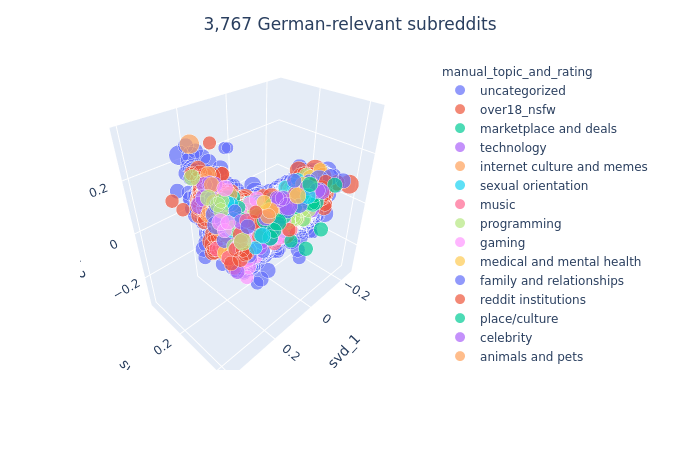

CPU times: user 492 ms, sys: 63.5 ms, total: 556 ms
Wall time: 4.29 s


In [38]:
%%time

df_plot_ = (
    df_subs_meta_plot  #[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
)

l_custom_data_subs = [
  'subreddit_name', 
  col_manual_labels,
  # 'text_1',
  # 'text_2',
]
sub_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
    # "post text: %{customdata[2]}",
    # "  %{customdata[3]}"
])

fig = px.scatter_3d(
    df_plot_,
    y='svd_0', x='svd_1', z='svd_2',
    color=col_manual_labels,  # color=col_manual_labels,
    custom_data=l_custom_data_subs,
    size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
    # hoverinfo='text',
)

fig.update_traces(hovertemplate=sub_hover_data)
fig.update_layout(
    title_text=(
        # f"Most similar subreddits to <i>r/{sub_}</i>"
        f"{len(df_subs_meta_plot):,.0f} German-relevant subreddits"
        # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
        # f"<br>Using posts from 04-01-2021 to 05-08-2021"
    ),
    title_x=0.5,
    width=800,
    height=600,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

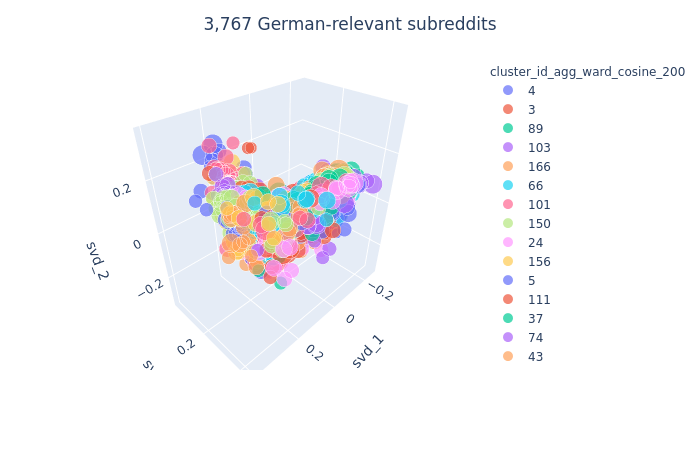

CPU times: user 1.17 s, sys: 12 ms, total: 1.18 s
Wall time: 5.59 s


In [39]:
%%time

df_plot_ = (
    df_subs_meta_plot  #[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
)

l_custom_data_subs = [
  'subreddit_name', 
  col_manual_labels,
  # 'text_1',
  # 'text_2',
]
sub_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
    # "post text: %{customdata[2]}",
    # "  %{customdata[3]}"
])

fig = px.scatter_3d(
    df_plot_,
    y='svd_0', x='svd_1', z='svd_2',
    color=col_clustering,  # color=col_manual_labels,
    custom_data=l_custom_data_subs,
    size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
    # hoverinfo='text',
)

fig.update_traces(hovertemplate=sub_hover_data)
fig.update_layout(
    title_text=(
        # f"Most similar subreddits to <i>r/{sub_}</i>"
        f"{len(df_subs_meta_plot):,.0f} German-relevant subreddits"
        # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
        # f"<br>Using posts from 04-01-2021 to 05-08-2021"
    ),
    title_x=0.5,
    width=800,
    height=600,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

## Append subreddit label to pair-wise df

Use it to show when a sub was found to be related or not to a related sub.

In [94]:
# col_cluster_id_b = 'cluster_id_b'
# df_sub_d_pair = (
#     df_sub_d_pair.merge(
#         df_subs_meta_plot[['subreddit_name', col_clustering]].rename(columns={'subreddit_name': 'subreddit_name_b'}),
#         how='left',
#         on=['subreddit_name_b'],
#     )
#     .rename(columns={col_clustering: col_cluster_id_b})
# )



In [95]:
# list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns)

In [98]:
# reorder columns so it's easier to see topic
l_cols_sub_ids = ['subreddit_id_a', 'subreddit_id_b']

df_sub_d_pair = df_sub_d_pair[(
    reorder_array(
        ['cosine_distance', 'subreddit_name_a', 'subreddit_name_b',  # col_cluster_id_b,
         'rating_b', 'topic_b',
         'primary_post_language_b', 'primary_post_language_percent_b',
         'post_median_word_count_b',
         # 'manual_topic_and_rating_b', 
        ],
        list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns) + l_cols_sub_ids,
    )
)]

In [99]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,post_median_word_count_b,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,post_median_word_count_a,subreddit_id_a,subreddit_id_b
0,0.719657,1071,tamamahbapengelli,None,None,Turkish,0.677419,4.0,None,None,Turkish,0.845133,9.0,t5_4ppr4q,t5_pwwzi
1,0.708699,1071,nonakanal,None,None,German,0.712589,6.0,None,None,Turkish,0.845133,9.0,t5_4ppr4q,t5_2ltn31
2,0.706756,1071,okemakkermaloot,None,None,Dutch,0.358974,3.0,None,None,Turkish,0.845133,9.0,t5_4ppr4q,t5_pa6tc
3,0.706363,1071,kudurdum,None,None,Turkish,0.544170,7.0,None,None,Turkish,0.845133,9.0,t5_4ppr4q,t5_2pn1vr
4,0.698231,1071,okbrudimongo,r,Internet Culture and Memes,German,0.651042,4.0,None,None,Turkish,0.845133,9.0,t5_4ppr4q,t5_ofkj1


# Define functions & cols to display

In [100]:
# [c for c in df_subs_meta_plot.columns if 'cluster_id' in c]

In [110]:
col_manual_labels = 'manual_topic_and_rating'
cols_to_front = [
    'subreddit_name',
    
    'rating',
    'topic',
    
    'subreddit_title',
    # Use predominant language instead of specific language col
    'primary_post_language',
    'primary_post_language_percent',
    'primary_post_type',
    'primary_post_type_percent',


#     'subreddit_public_description',
    
]
cols_to_exclude = [
    'subreddit_description',
    'subreddit_name_title_and_clean_descriptions',
    
    # cluster info not needed for now
    'cluster_id_kmeans20_all',
    'cluster_id_agg_ward_25',
    'cluster_id_agg_ward_35',
#     'cluster_id_agg_ward_cosine_35',
    'cluster_id_agg_avg_cosine_35',
    'cluster_id_agg_complete_cosine_35',
    'cluster_id_kmeans8',
    'cluster_id_kmeans15',
    'cluster_id_kmeans20',
    'cluster_id_hdbscan_cosine',
    'cluster_id_hdbscan_euclidean',
    'cluster_id_hdbscan_cosine_soft'

]

In [111]:

cols_to_display = cols_to_front + [

    'users_l28',
    'posts_l28',
    'comments_l28',
    
    'post_median_word_count',
    
    'primary_post_language_in_use_multilingual',
    
#     'English_posts_percent',
#     'other_language_posts_percent',
    
#     'image_post_type_percent',
#     'text_post_type_percent',
#     'link_post_type_percent',
#     'other_post_type_percent',
    
    'manual_topic_and_rating',
    'rating_version',
    'over_18',
    
#     'subreddit_name_title_and_clean_descriptions_word_count',
]
# cols_to_display

In [112]:
# pd.set_option('display.max_colwidth', 180)
# pd.set_option('display.width', 200)

In [113]:
def display_items_for_cluster_id(
    df_subs_meta_plot,
    id_,
    cols_to_display=cols_to_display,
    col_manual_labels=col_manual_labels,
    n_subs_to_show: int = 15,
    set_subreddit_title_width: int = None,
    set_topic_width: int = 120,
) -> None:
    """
    """
    mask_ = df_subs_meta_plot[col_clustering] == id_
    print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    

    display(
        value_counts_and_pcts(
            df_subs_meta_plot[mask_][col_manual_labels],
            add_col_prefix=False,
            reset_index=True,
            cumsum=False,
        ).hide_index()
    )
    l_bar_simple = [
        'primary_post_language_percent',
        'German_posts_percent', 'English_posts_percent',
        'image_post_type_percent', 'text_post_type_percent',
        'users_l28',
    ]
    if set_subreddit_title_width is not None:
        display(
            style_df_numeric(
                df_subs_meta_plot[mask_][cols_to_display]
                .sort_values(by=['users_l28'], ascending=False)
                .head(n_subs_to_show)
                ,
                rename_cols_for_display=True,
                l_bar_simple=l_bar_simple
            )
            .set_properties(subset=['subreddit title'], **{'width': f'{set_subreddit_title_width}px'})
            .set_properties(subset=['topic'], **{'width': f'{set_topic_width}px'})
            .hide_index()
        )
    else:
        display(
            style_df_numeric(
                df_subs_meta_plot[mask_][cols_to_display]
                .sort_values(by=['users_l28'], ascending=False)
                .head(n_subs_to_show)
                ,
                rename_cols_for_display=True,
                l_bar_simple=l_bar_simple
            )
            .set_properties(subset=['topic'], **{'width': f'{set_topic_width}px'})
            .hide_index()
        )

# Examples

For a given subreddit, show:
- closest subreddits (pair)
- cluster assigned by Machine Learning model

In [114]:
[c for c in df_sub_meta['subreddit_name'] if 'finan' in c]

['personalfinance',
 'povertyfinance',
 'finanzen',
 'finance',
 'ethfinance',
 'financial']

,cosine distance,subreddit name a,subreddit name b,rating b,topic b,primary post language b,primary post language percent b,post median word count b,rating a,topic a,primary post language a,primary post language percent a,post median word count a
0,0.8761,bundesliga,fussball,None,None,German,62.40%,14,pg13,Sports,English,61.15%,12
1,0.8750,bundesliga,fohlenelf,pg13,None,English,91.30%,10,pg13,Sports,English,61.15%,12
2,0.8664,bundesliga,borussiadortmund,pg13,None,English,89.76%,16,pg13,Sports,English,61.15%,12
3,0.8618,bundesliga,schalke04,pg,None,English,72.82%,12,pg13,Sports,English,61.15%,12
4,0.8386,bundesliga,vfbstuttgart,pg,None,English,86.54%,12,pg13,Sports,English,61.15%,12
5,0.8338,bundesliga,soccer,pg13,None,English,87.50%,18,pg13,Sports,English,61.15%,12
6,0.8288,bundesliga,effzeh,pg,None,English,93.65%,14,pg13,Sports,English,61.15%,12
7,0.8215,bundesliga,elf,None,None,English,95.86%,21,pg13,Sports,English,61.15%,12
8,0.8147,bundesliga,eintracht,pg,None,English,62.50%,9,pg13,Sports,English,61.15%,12
9,0.8107,bundesliga,svw,None,None,English,78.26%,17,pg13,Sports,English,61.15%,12



Cluster ID: 81
  21 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,17,81.0%
sports,4,19.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post type,primary post type percent,users l28,posts l28,comments l28,post median word count,primary post language in use multilingual,manual topic and rating,rating version,over 18
soccer,pg13,None,The back page of the internet,English,87.50%,link,80.25%,"3,689,781","16,443","1,817,884",18,True,uncategorized,v2,f
football,pg13,None,Football - The People's Sport,English,74.25%,link,51.75%,"372,114","2,332","18,850",14,True,uncategorized,v2,f
worldcup,pg,None,World Cup,English,96.00%,link,49.14%,"49,226",148,"1,071",22,True,uncategorized,v1,f
bundesliga,pg13,Sports,German Bundesliga: News & Highlights,English,61.15%,link,59.71%,"27,771",122,"1,537",12,True,sports,v1,None
borussiadortmund,pg13,None,Borussia Dortmund,English,89.76%,text,40.00%,"27,412",152,"4,064",16,True,uncategorized,v2,f
championsleague,pg,Sports,UEFA Champions League,English,96.00%,link,56.00%,"8,972",40,109,10,True,sports,v3,f
euro,None,None,Strictly Euro news,English,80.91%,link,56.36%,"8,883",96,89,8,True,uncategorized,None,f
futbol,None,None,Todo sobre el fútbol mundial,Turkish,83.83%,link,92.25%,"6,656","1,047",79,19,True,uncategorized,None,f
fussball,None,None,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,German,62.40%,link,47.57%,"4,180",272,527,14,True,uncategorized,None,None
schalke04,pg,None,FC Schalke 04,English,72.82%,link,50.49%,"3,238",66,433,12,True,uncategorized,v1,None


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



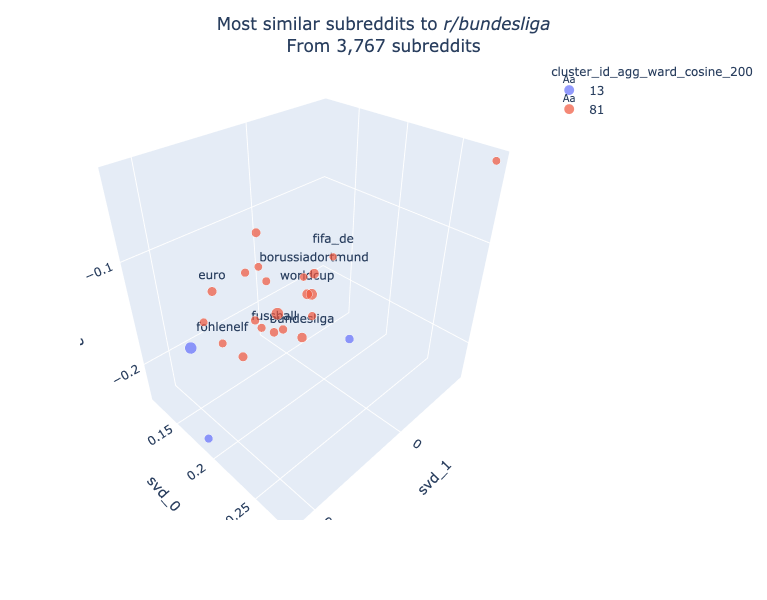

,cosine distance,subreddit name a,subreddit name b,rating b,topic b,primary post language b,primary post language percent b,post median word count b,rating a,topic a,primary post language a,primary post language percent a,post median word count a
0,0.8693,ameisenstrassenwetten,mauerstrassenwetten,r,Internet Culture and Memes,German,87.96%,9,None,None,German,88.37%,12
1,0.8126,ameisenstrassenwetten,farialimabets,None,None,Portuguese,70.94%,9,None,None,German,88.37%,12
2,0.7751,ameisenstrassenwetten,dalalstreetbets,not_shown_in_theaters,"Business, Economics, and Finance",English,84.47%,12,None,None,German,88.37%,12
3,0.7745,ameisenstrassenwetten,wallstreetbets,r,None,English,90.83%,14,None,None,German,88.37%,12
4,0.7664,ameisenstrassenwetten,aktien,None,None,German,96.74%,38,None,None,German,88.37%,12
5,0.7089,ameisenstrassenwetten,stockstobuytoday,None,None,English,94.52%,16,None,None,German,88.37%,12
6,0.7056,ameisenstrassenwetten,amcstock,None,None,English,88.67%,12,None,None,German,88.37%,12
7,0.7025,ameisenstrassenwetten,stock,None,None,English,83.33%,20,None,None,German,88.37%,12
8,0.6983,ameisenstrassenwetten,etc,None,None,English,96.10%,18,None,None,German,88.37%,12
9,0.6981,ameisenstrassenwetten,ecomi,None,None,English,93.25%,21,None,None,German,88.37%,12



Cluster ID: 22
  28 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,22,78.6%
"business, economics, and finance",4,14.3%
over18_nsfw,1,3.6%
internet culture and memes,1,3.6%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post type,primary post type percent,users l28,posts l28,comments l28,post median word count,primary post language in use multilingual,manual topic and rating,rating version,over 18
wallstreetbets,r,None,wallstreetbets,English,90.83%,image,35.67%,"7,636,762","43,615","1,187,212",14,True,uncategorized,v2,f
amcstock,None,None,amcstock,English,88.67%,image,65.42%,"1,864,135","46,778","980,536",12,True,uncategorized,None,f
stocks,not_shown_in_theaters,None,Stocks - Investing and trading for all,English,100.00%,text,99.92%,"1,842,886","5,356","99,648",117,True,uncategorized,v2,f
investing,pg13,None,Lose money with friends!,English,99.50%,text,100.00%,"1,284,784","3,641","55,567",140,True,uncategorized,v1,f
pennystocks,r,None,Welcome to /r/pennystocks,English,98.67%,text,73.17%,"689,835","3,388","41,325",191,True,uncategorized,v1,f
options,pg13,None,/r/Options,English,100.00%,text,92.67%,"593,598","2,453","33,751",94,True,uncategorized,v2,f
finanzen,pg,"Business, Economics, and Finance",Fragen und Antworten zu Finanzen,German,96.00%,text,82.00%,"233,475","1,096","29,755",103,True,"business, economics, and finance",v1,None
dividends,pg13,None,Dividend Investing,English,99.69%,text,92.86%,"164,369",746,"15,064",75,True,uncategorized,v2,f
mauerstrassenwetten,r,Internet Culture and Memes,mauerstrassenwetten,German,87.96%,image,53.98%,"133,744",653,"56,007",9,True,internet culture and memes,None,None
aktien,None,None,"Aktien, Handel und Investmentstrategien",German,96.74%,text,84.57%,"22,071",306,"2,023",38,True,uncategorized,None,f


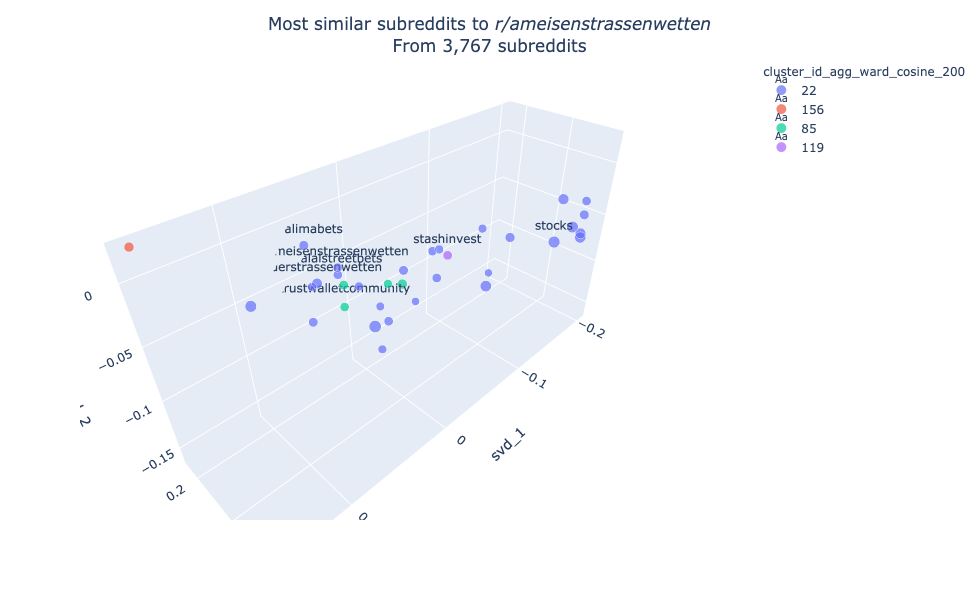

CPU times: user 1.83 s, sys: 11.7 ms, total: 1.84 s
Wall time: 1.81 s


In [115]:
%%time

display_plot_png = False
display_plot_js = True

for sub_ in ['bundesliga', 'ameisenstrassenwetten']:
# for sub_ in ['american_football', 'nfl', 'raiders',]:  # 'baseball',
# for sub_ in ['american_football', 'futbol', 'bundesliga', 'finanzen', 'finance']:
# for sub_ in ['hamburg', 'germanrap', 'de_iama', 'bundesliga', 'finanzen', 'vegande', 'ich_iel']:
    # closest subs
    df_closest_subs_ = (
        df_sub_d_pair[df_sub_d_pair['subreddit_name_a'] == sub_]
        .sort_values(by='cosine_distance', ascending=False)
        .drop(['subreddit_id_a', 'subreddit_id_b'], axis=1)
        .reset_index(drop=True)
        .head(20)
    )
    l_closest_subs = [sub_] + list(df_closest_subs_['subreddit_name_b'])

    display(
        style_df_numeric(
            df_closest_subs_,
            rename_cols_for_display=True,
            l_bar_simple=['cosine_distance', 'primary_post_language_percent_b'],
            float_round=4,
        )  #.hide_index()
    )

    # cluster assigned by ML
    sub_id = df_subs_meta_plot.loc[df_subs_meta_plot['subreddit_name'] == sub_,
                                   col_clustering].values[0]
    l_subs_in_cluster = list(
        df_subs_meta_plot[df_subs_meta_plot[col_clustering] == sub_id]
        ['subreddit_name']
    )

    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=sub_id,
    )

    set_subs_all_similar = set(l_closest_subs) | set(l_subs_in_cluster)
    # print(set_subs_all_similar)
    
    
    if (display_plot_png | display_plot_js):
        # display overlap between closest subs and subs that are part of the selected cluster
        # options:
        #  - Could display in SVD or t-sne space as dots
        #  - Could display as a table with flags for cluster IDs & distances
        #. - or venn diagram?
        # works with recent plotly (custom data)
        df_plot_ = (
            df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
        )
        
        # Select subs to display: self + 3 closest & 3 furthest away
        # assumes closest subs has already been sorted
        l_names_to_show = (
            [sub_] + 
            list(df_closest_subs_['subreddit_name_b'].head(3)) + 
            list(df_closest_subs_['subreddit_name_b'].tail(3))
        )
        df_plot_['subreddit_name_sparse'] = np.where(
            df_plot_['subreddit_name'].isin(l_names_to_show),
            df_plot_['subreddit_name'],
            ''
        )
        

        l_custom_data_subs = [
          'subreddit_name', 
          col_manual_labels,
          # 'text_1',
          # 'text_2',
        ]
        sub_hover_data = "<br>".join([
            "subreddit name: %{customdata[0]}",
            "subreddit manual label: %{customdata[1]}",
            # "post text: %{customdata[2]}",
            # "  %{customdata[3]}"
        ])

        fig = px.scatter_3d(
            df_plot_,
            y='svd_0', x='svd_1', z='svd_2',
            color=col_clustering,  # color=col_manual_labels,
            custom_data=l_custom_data_subs,
            size=100 * np.log2(1 + df_plot_['users_l28']),
            text='subreddit_name_sparse',
            # hoverinfo='text',
        )

        fig.update_traces(hovertemplate=sub_hover_data)
        fig.update_layout(
            title_text=(
                f"Most similar subreddits to <i>r/{sub_}</i>"
                f"<br>From {len(df_subs_meta_plot):,.0f} subreddits"
                # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
                # f"<br>Using posts from 04-01-2021 to 05-08-2021"
            ),
            title_x=0.5,
            width=800,
            height=600,
        #     uniformtext_minsize=8, uniformtext_mode='hide'
        )
        if display_plot_png:
            fig.show(renderer='png')
        if display_plot_js:
            fig.show()

# Loop through clusters that have at least one German Subreddit

In reality, these will be the primary use case to find recommendations.
Subs that are:
- Germany geo-relevant
- From German ambassador program
- Primarily in German

### Get subreddit IDs for Germany-relevant subs

Need to load the data from a separate dataframe that has the geo-relevant ranks!

In [58]:
df_sub_meta.shape

(3767, 74)

In [61]:
[c for c in df_sub_meta.columns if 'count' in c]

['subreddit_clean_description_word_count',
 'subreddit_name_title_and_clean_descriptions_word_count',
 'post_median_word_count']

In [62]:
[c for c in df_sub_meta.columns if 'lang' in c]

['subreddit_language',
 'Other language_posts_percent',
 'primary_post_language',
 'primary_post_language_percent',
 'primary_post_language_in_use_multilingual']

In [78]:
# df_sub_meta.iloc[:5, :25]

In [71]:
# find subs that are germany re
# df_subs_meta_plot.head()

# Loop through all clusters

In [75]:
# # cluster assigned by ML
# for id_ in tqdm(list(sorted(df_subs_meta_plot[col_clustering].unique()))[:10]):
#     display_items_for_cluster_id(
#         df_subs_meta_plot=df_subs_meta_plot,
#         id_=id_,
#         set_subreddit_title_width=200,
#         set_topic_width=140,
#     )

In [80]:
# cluster assigned by ML
for id_ in tqdm(list(sorted(df_subs_meta_plot[col_clustering].unique()))[100:115]):
    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=id_,
    )

  0%|          | 0/15 [00:00<?, ?it/s]


Cluster ID: 189
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,7,70.0%
technology,3,30.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
verizon,pg,None,The Official Unofficial Hub For All Verizon Discussion,English,99.33%,True,"275,573",852,"8,662",82,0.00%,96.92%,uncategorized,v1,f
mintmobile,g,None,Mint Mobile,English,99.56%,True,"74,503",319,"2,853",66,5.56%,86.89%,uncategorized,v1,f
mobilerepair,pg13,None,Mobile Device Repair | MBL.REPAIR,English,99.21%,True,"65,907",389,"2,675",64,14.43%,70.16%,uncategorized,v2,f
blackberry,pg,None,BlackBerry,English,96.89%,True,"29,678",152,"1,049",29,11.56%,68.89%,uncategorized,v1,f
shaw,pg,None,The official Shaw Communications subreddit.,English,98.55%,True,"20,775",46,518,68,10.14%,78.26%,uncategorized,v1,f
motorola,pg,Technology,For everything Motorola.,English,100.00%,True,"13,389",221,384,66,6.90%,86.21%,technology,v3,f
oneplus7t,pg,Technology,OnePlus 7T,English,97.65%,True,"5,471",95,583,31,17.06%,57.06%,technology,v3,f
phones,pg,None,All about Phones,English,99.41%,True,"4,243",148,351,70,0.00%,99.41%,uncategorized,v2,f
cellphones,pg,Technology,"Cell Phone and Service Provider Reviews, News, Deals, Tech Support and Discussion.",English,97.27%,True,"4,179",76,192,66,7.27%,76.36%,technology,v3,f
blackberrygang,None,None,blackberrygang,English,95.12%,True,"1,860",56,123,17,7.32%,60.98%,uncategorized,None,f



Cluster ID: 19
  17 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,13,76.5%
technology,2,11.8%
learning and education,1,5.9%
programming,1,5.9%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
ender3,pg,None,Ender 3,English,95.17%,True,"204,182","1,856","18,290",14,38.25%,17.33%,uncategorized,v1,f
arduino,pg,None,Arduino,English,96.75%,True,"182,689","1,367","10,054",52,9.92%,54.50%,uncategorized,v1,f
photoshop,pg,None,Adobe Photoshop,English,97.00%,True,"170,282","1,327","4,977",20,40.83%,30.67%,uncategorized,v1,f
electronics,pg13,None,Electronic systems and circuits,English,91.56%,True,"84,840",731,"2,894",12,26.22%,26.22%,uncategorized,v2,f
cad,g,None,CAD - Computer-Aided Design,English,98.48%,True,"52,085",212,"1,148",66,12.69%,74.11%,uncategorized,v1,f
embedded,pg,None,Embedded,English,99.03%,True,"47,869",297,"3,328",110,1.62%,89.29%,uncategorized,v1,f
batteries,g,None,Battery technology,English,99.20%,True,"40,084",249,"1,689",72,10.96%,71.39%,uncategorized,v1,f
opengl,pg,Programming,"OpenGL: Open Graphics Library - a community for discussion, help and news.",English,95.60%,True,"35,380",109,750,60,5.03%,59.75%,programming,v3,f
ender5,g,None,Creality Ender 5,English,96.83%,True,"32,893",181,"1,724",47,14.41%,51.30%,uncategorized,v1,f
klippers,g,None,Klippers -- A Place for Fellow Users of the Klipper Firmware,English,96.28%,True,"21,446",122,"1,067",86,5.32%,77.66%,uncategorized,v1,f



Cluster ID: 190
  19 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,18,94.7%
music,1,5.3%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
spotify,g,None,Spotify,English,96.17%,True,"519,808","4,690","6,549",36,0.00%,63.25%,uncategorized,v1,f
beatsaber,g,None,The Beat Saber Subreddit!,English,91.67%,True,"145,518","1,097","8,144",16,17.25%,37.83%,uncategorized,v1,f
riprequests,g,None,Looking for album/song rips? Welcome to RipRequests!,English,90.33%,True,"91,247","1,982","4,641",23,2.92%,79.08%,uncategorized,v1,f
rocksmith,pg13,None,"Rocksmith+ ""Subscription Complaint Desk""",English,98.19%,True,"85,132",533,"7,508",44,10.97%,72.92%,uncategorized,v2,f
rhythmgames,pg,None,Rhythm Games,English,90.69%,True,"39,358",209,984,13,16.22%,39.64%,uncategorized,v1,f
musicians,g,None,musicians subreddit,English,90.42%,True,"18,205",861,"1,430",17,2.50%,35.67%,uncategorized,v1,f
chiptunes,pg13,None,The place on Reddit for Chiptune music!,English,88.72%,True,"13,070",237,582,12,0.89%,18.99%,uncategorized,v2,f
karaoke,pg,None,Karaoke,English,93.85%,True,"10,444",61,242,59,3.08%,81.54%,uncategorized,v1,f
audius,pg,Music,Audius,English,87.21%,True,"5,989",113,502,22,2.91%,45.35%,music,v3,f
lyrics,r,None,For the lyrically inclined,English,88.43%,True,"5,690",386,96,94,0.00%,66.67%,uncategorized,v2,f



Cluster ID: 191
  21 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,11,52.4%
over18_nsfw,4,19.0%
anime,4,19.0%
podcasts and streamers,1,4.8%
television,1,4.8%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
anime,pg,None,/r/Anime,English,88.83%,True,"4,361,634","16,527","287,420",15,5.00%,39.17%,uncategorized,v1,f
manga,r,None,"/r/manga: manga, on reddit.",English,76.42%,True,"2,394,078","9,723","106,333",9,23.42%,1.58%,uncategorized,v1,f
evangelion,nc17,None,Evangelion,English,79.08%,True,"396,778","1,384","11,837",10,46.17%,21.92%,over18_nsfw,v2,f
visualnovels,pg13,None,Visual Novels,English,96.83%,True,"277,395","1,095","12,342",43,11.33%,64.33%,uncategorized,v2,f
sololeveling,pg13,None,Solo Leveling,English,89.54%,True,"256,500",577,"7,340",12,38.56%,33.01%,uncategorized,v2,f
boyslove,r,Anime,"BL is love, BL is life",English,90.27%,True,"148,470",606,"8,024",20,24.59%,45.68%,anime,v3,f
mangadex,pg13,None,mangadex: a scanlator friendly manga hosting site,English,97.08%,True,"126,801",429,"3,003",39,9.93%,82.04%,uncategorized,v1,f
hanakokun,pg13,Anime,Toilet-bound Hanako-kun,English,80.36%,True,"51,213",433,"3,869",9,58.64%,13.00%,anime,v3,f
toloveru,nc17,None,To Love Ru,English,84.82%,True,"46,083",148,"1,131",11,26.34%,32.59%,over18_nsfw,v1,f
kof,r,None,The King of Fighters,English,82.42%,True,"41,090",461,"4,654",10,36.88%,23.04%,uncategorized,v2,f



Cluster ID: 192
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,10,100.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
torrents,r,None,r/torrents - Torrenting Discussion and News,English,98.26%,True,"304,459",438,"1,188",43,21.51%,73.84%,uncategorized,v2,f
antivirus,pg,None,Antivirus,English,97.91%,True,"191,462",476,"2,617",58,9.95%,80.58%,uncategorized,v1,f
onions,pg,None,/r/onions: Things That Make You Cry | Tor Onion Routing Hidden Services,English,95.53%,True,"157,706",398,"1,965",26,12.37%,82.13%,uncategorized,v1,f
opendirectories,pg,None,Open Directories,English,89.29%,True,"154,089",124,674,20,1.43%,64.29%,uncategorized,v1,f
thepiratebay,r,None,thepiratebay,English,94.40%,True,"95,085",82,430,23,6.40%,72.80%,uncategorized,v1,f
usenet,pg13,None,r/usenet - Usenet Discussion,English,96.09%,True,"62,747",209,"1,557",66,0.00%,94.53%,uncategorized,v2,f
computerviruses,None,None,"Computer Viruses, Spyware, and Trojans",English,97.83%,True,"27,754",96,434,52,10.87%,75.36%,uncategorized,None,f
irc,pg,None,"Internet Relay Chat! (Announcements, Support, QDB)",English,98.44%,True,"22,735",44,369,35,3.12%,65.62%,uncategorized,v1,f
mullvadvpn,None,None,Mullvad VPN,English,100.00%,True,"13,220",70,429,66,0.86%,87.07%,uncategorized,None,f
surfshark,None,None,Surfshark,English,97.78%,True,"2,358",52,155,74,6.67%,82.22%,uncategorized,None,f



Cluster ID: 193
  7 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,5,71.4%
uncategorized,2,28.6%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
sex,x,None,Sex,English,100.00%,True,"5,559,601","13,850","140,207",148,0.00%,100.00%,over18_nsfw,v1,f
bigdickproblems,r,None,BigDickProblems,English,99.58%,True,"641,785","1,617","25,467",71,1.42%,97.67%,uncategorized,v1,f
averagedickproblems,nc17,None,Dick Problems and Male Sexuality,English,100.00%,True,"106,485",239,"1,548",70,0.00%,95.76%,over18_nsfw,v1,f
smalldickproblems,x,None,SDP,English,99.35%,True,"103,647",272,"4,536",96,0.00%,100.00%,over18_nsfw,v1,f
sexeducation,nc17,None,Sex Education Discussion,English,97.77%,True,"16,465",128,495,75,0.56%,93.85%,over18_nsfw,v2,f
sexualhealth,nc17,None,Sexual Health,English,99.28%,True,"9,303",181,631,101,0.00%,100.00%,over18_nsfw,v1,f
menshealth,r,None,Men's Health,English,99.27%,True,"8,346",187,550,72,4.74%,83.94%,uncategorized,v2,f



Cluster ID: 194
  5 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,5,100.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
solar,pg,None,Solar,English,98.89%,True,"70,710",573,"6,716",74,5.82%,73.41%,uncategorized,v1,f
energy,pg,None,/r/Energy: News & Discussion,English,97.78%,True,"45,214",635,"8,243",14,0.11%,14.43%,uncategorized,v1,f
nuclear,pg,None,Nuclear,English,98.49%,True,"11,386",162,"1,298",13,3.02%,28.14%,uncategorized,v1,f
solarenergy,g,None,Solar Energy,English,93.46%,True,"4,421",103,377,25,6.54%,46.41%,uncategorized,v1,f
wind,pg,None,Wind power news and articles,English,98.41%,True,"3,068",52,125,13,0.00%,14.29%,uncategorized,v1,f



Cluster ID: 195
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,11,100.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
collapse,pg,None,Collapse of Civilization,English,98.67%,True,"325,272","1,970","89,867",16,4.08%,26.33%,uncategorized,v1,f
environment,pg,None,environment,English,99.08%,True,"198,468","2,401","12,566",13,0.00%,1.50%,uncategorized,v1,f
climate,pg,None,Information about the world's climate,English,98.71%,True,"47,413",714,"5,079",14,0.00%,14.89%,uncategorized,v1,f
sustainability,pg,None,Sustainability: The Capacity to Endure,English,97.56%,True,"46,075",452,"3,194",17,8.43%,39.25%,uncategorized,v1,f
climatechange,pg13,None,A place for a rational discussion on a divisive topic.,English,98.60%,True,"38,656",460,"3,692",24,1.40%,49.72%,uncategorized,v2,f
nature,g,None,Nature,English,95.48%,True,"29,153",673,"1,150",12,0.00%,6.45%,uncategorized,v1,f
ecology,pg,None,Ecology,English,97.00%,True,"15,555",156,567,16,2.00%,32.50%,uncategorized,v1,f
climateskeptics,not_shown_in_theaters,None,Climate Skeptics: Trying to see through the alarmism,English,93.29%,True,"14,699",563,"6,724",13,4.93%,17.40%,uncategorized,v2,f
conservation,pg13,None,Conservation,English,96.61%,True,"6,894",138,231,13,0.00%,16.95%,uncategorized,v2,f
umwelt_de,None,None,umwelt_de,German,97.50%,True,636,47,44,10,6.25%,3.75%,uncategorized,None,None



Cluster ID: 196
  6 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,4,66.7%
medical and mental health,1,16.7%
religion and spirituality,1,16.7%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
glasses,pg,None,Glasses,English,98.49%,True,"91,767",480,"2,263",32,23.56%,55.89%,uncategorized,v1,f
sunglasses,g,None,For everything about sunglasses!,English,96.11%,True,"64,835",363,"1,016",13,39.41%,29.91%,uncategorized,v1,f
eyes,pg,None,Gorgeous Eyes,English,82.83%,True,"36,671",648,"2,635",7,69.25%,0.00%,uncategorized,v1,f
eyetriage,pg,None,eyetriage,English,97.74%,True,"14,464",148,881,83,14.34%,70.57%,uncategorized,v2,f
contacts,r,Medical and Mental Health,Reddit Contacts - Find the people you're looking for,English,99.20%,True,"3,766",90,333,68,2.40%,92.80%,medical and mental health,v3,f
aurareadings,pg13,Religion and Spirituality,Aura Readings,English,97.60%,True,795,53,142,12,69.60%,12.00%,religion and spirituality,v3,f



Cluster ID: 197
  4 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,2,50.0%
over18_nsfw,1,25.0%
beauty and makeup,1,25.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
beards,pg,None,bearddit: the chin of the internet -- news before it grows,English,91.25%,True,"219,584","1,398","10,079",8,76.67%,0.00%,uncategorized,v1,f
shorthairedhotties,nc17,None,Shorthaired hotties,English,78.85%,True,"57,269",266,"1,744",6,67.58%,0.00%,over18_nsfw,v1,f
longhair,pg13,None,Long Hair,English,92.96%,True,"47,643",325,"3,697",14,44.58%,22.38%,uncategorized,v2,f
braids,pg,Beauty and Makeup,Braids & Braided Hairstyles,English,87.65%,True,"5,862",51,274,10,45.68%,11.11%,beauty and makeup,v3,f



Cluster ID: 198
  30 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,29,96.7%
learning and education,1,3.3%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
uwaterloo,None,Learning and Education,University of Waterloo,English,94.00%,True,"151,853","1,308","11,178",25,17.58%,66.17%,learning and education,None,f
berkeley,pg,None,Berkeley,English,98.33%,True,"147,374","1,629","8,766",51,5.75%,89.50%,uncategorized,v1,f
ucla,pg,None,UCLA,English,98.83%,True,"143,345","1,871","7,653",33,4.08%,89.42%,uncategorized,v1,f
ucf,pg,None,University of Central Florida,English,99.03%,True,"89,813",619,"3,576",47,7.48%,86.85%,uncategorized,v1,f
gatech,pg,None,Time to buzzit,English,98.13%,True,"79,939",520,"2,794",50,7.03%,83.84%,uncategorized,v1,f
aggies,pg,None,The Best Student Section on Reddit!,English,98.22%,True,"68,476",665,"5,781",40,12.17%,78.34%,uncategorized,v1,f
udub,pg13,None,University of Washington,English,98.29%,True,"60,857",543,"3,080",50,2.80%,89.88%,uncategorized,v2,f
nyu,pg13,None,New York University,English,98.97%,True,"50,646",630,"2,641",43,1.03%,96.80%,uncategorized,v2,f
ryerson,pg13,None,Ryerson University,English,99.03%,True,"49,778",378,"2,180",55,3.87%,91.88%,uncategorized,v2,f
msu,pg13,None,Michigan State University,English,96.91%,True,"47,099",344,"2,190",44,5.35%,87.04%,uncategorized,v2,f



Cluster ID: 199
  24 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,20,83.3%
gaming,4,16.7%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
modernwarfare,r,None,Call of Duty: Modern Warfare | Reddit,English,93.67%,True,"1,703,946","5,782","47,908",11,14.08%,24.58%,uncategorized,v2,f
fo76,pg13,None,Fallout 76 | Reddit,English,99.67%,True,"873,913","8,603","132,980",64,0.00%,99.67%,uncategorized,v1,f
outriders,r,Gaming,Outriders,English,95.83%,True,"318,668","2,262","31,302",26,29.00%,43.08%,gaming,v3,f
apexuniversity,pg13,None,/r/ApexUniversity,English,97.50%,True,"226,950","1,057","16,239",32,3.42%,55.92%,uncategorized,v2,f
starcraft,pg,None,Starcraft on Reddit,English,92.17%,True,"202,183","1,051","12,927",15,21.08%,38.58%,uncategorized,v1,f
aimlab,pg13,None,Aim Lab - FPS Aim Trainer,English,92.80%,True,"86,069",380,"1,721",28,20.64%,50.88%,uncategorized,v2,f
startrekfleetcommand,pg13,None,Star Trek Fleet Command,English,94.08%,True,"60,778",98,"1,202",26,13.82%,69.08%,uncategorized,v2,f
vigorgame,r,None,Vigor �� Free-to-Play Shoot 'n' Loot,English,92.82%,True,"42,601",738,"7,766",17,22.60%,46.07%,uncategorized,v2,f
worldwarzthegame,r,None,World War Z - The Game,English,97.36%,True,"40,178",184,"1,749",35,7.92%,67.92%,uncategorized,v1,f
battletech,g,None,all things battletech,English,95.82%,True,"33,547",377,"5,247",17,25.65%,36.17%,uncategorized,v1,f



Cluster ID: 2
  53 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,45,84.9%
music,7,13.2%
"culture, entertainment, music",1,1.9%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
listentothis,pg13,None,Listen To This,English,71.58%,True,"231,842","6,546","6,044",8,0.00%,0.08%,uncategorized,v2,f
punk,pg13,None,Punk,English,88.33%,True,"135,057","1,546","14,304",11,11.92%,25.17%,uncategorized,v2,f
electronicmusic,pg,None,Beep Bloop. A place to discuss everything electronic music related.,English,77.00%,True,"118,046","1,729","4,069",7,1.25%,13.33%,uncategorized,v1,f
goth,pg,None,Reddit's Goth Community,English,89.28%,True,"99,680",488,"3,388",9,7.88%,32.82%,uncategorized,v1,f
trap,pg13,None,/r/trap - The best subreddit on the internet,English,69.20%,True,"98,483",759,"2,367",6,2.96%,9.02%,uncategorized,v2,f
germanrap,r,Music,Das Deutschrap-Forum,German,62.63%,True,"60,626",455,"4,276",7,10.44%,24.24%,"culture, entertainment, music",v2,None
shoegaze,pg13,None,shoegaze,English,85.82%,True,"49,145",500,"3,137",9,15.05%,18.81%,uncategorized,v2,f
mashups,pg13,None,The Home of MashUps,English,79.33%,True,"41,180",991,903,11,0.33%,10.67%,uncategorized,v2,f
dubstep,pg,None,/r/dubstep - The Home of Dubstep on Reddit,English,75.74%,True,"38,998",554,"1,964",6,2.51%,22.19%,uncategorized,v1,f
grunge,pg13,None,Grunge: The Seattle Sound,English,87.17%,True,"34,399",382,"2,673",11,18.00%,26.17%,uncategorized,v2,f



Cluster ID: 20
  34 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,19,55.9%
over18_nsfw,13,38.2%
beauty and makeup,1,2.9%
family and relationships,1,2.9%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
selfie,pg,None,Selfie,English,76.50%,True,"737,520","15,453","83,309",6,88.00%,0.00%,uncategorized,v1,f
dontputyourdickinthat,nc17,None,dontputyourdickinthat,English,74.75%,True,"625,057","2,683","15,878",4,47.58%,0.00%,over18_nsfw,v1,f
braless,nc17,None,braless: the way breasts were meant to be,English,83.68%,True,"390,358","1,751","11,695",6,78.18%,0.19%,over18_nsfw,v1,f
femboy,r,None,Appreciation for the femboy aesthetic!,English,79.83%,True,"377,993","6,549","39,708",6,93.33%,0.00%,uncategorized,v2,f
croptopgirls,None,None,Girls in crop tops,English,70.50%,True,"70,372",381,395,4,59.15%,0.63%,uncategorized,None,f
ebonyfeet,x,None,Ebony Feet,English,86.46%,True,"69,928",525,"2,344",6,77.76%,0.00%,over18_nsfw,v2,f
bigtittyclub,None,None,Big Titty Club - No Soliciting of Any Sites Allowed. READ ALL THE RULES!!!,English,75.53%,True,"54,473",583,"1,196",5,76.66%,0.49%,uncategorized,None,f
gayarmpitheaven,None,None,Gay Armpit Heaven,English,79.08%,True,"49,414",827,"2,725",5,77.00%,0.00%,uncategorized,None,f
peeling,pg13,None,peeling,English,85.96%,True,"44,500",101,582,7,28.07%,7.02%,uncategorized,v2,f
workoutgirls,None,None,WorkoutGirls,English,83.33%,True,"43,732",315,"1,057",5,77.55%,0.00%,uncategorized,None,f



Cluster ID: 21
  39 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,33,84.6%
food and drink,5,12.8%
hobbies,1,2.6%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
food,pg13,None,Welcome to /r/Food on Reddit!,English,60.92%,True,"1,474,012","10,168","57,846",5,91.50%,0.00%,uncategorized,v2,f
fastfood,pg,None,"Fast food news, reviews, and discussion",English,93.94%,True,"277,055",374,"3,400",12,0.00%,1.14%,uncategorized,v1,f
smoking,pg,None,Enhancing food with wood smoke flavor,English,85.75%,True,"241,242","1,957","23,102",9,42.25%,0.83%,uncategorized,v1,f
recipes,pg,None,recipes,English,70.43%,True,"236,343",586,"2,323",5,32.17%,0.00%,uncategorized,v2,f
grilling,pg13,None,Grilling! Tips and tricks for cooking over fire.,English,89.58%,True,"136,587",936,"7,353",9,41.25%,13.08%,uncategorized,v2,f
ramen,g,None,Ramen!,English,77.63%,True,"128,561",511,"3,753",10,60.07%,15.66%,uncategorized,v1,f
sushi,pg,None,The subreddit for all things sushi!,English,76.51%,True,"94,137",387,"2,815",8,59.97%,11.44%,uncategorized,v1,f
steak,g,None,Steak,English,87.57%,True,"89,736",448,"4,550",9,36.21%,10.39%,uncategorized,v1,f
hotsauce,pg13,None,Hot Sauce,English,94.39%,True,"73,245",469,"5,227",13,59.81%,17.76%,uncategorized,v2,f
bon_appetit,pg,None,Bon Appétit,English,91.16%,True,"48,717",111,732,11,34.01%,11.56%,uncategorized,v1,f


In [77]:
# # cluster assigned by ML
# for id_ in tqdm(list(sorted(df_subs_meta_plot[col_clustering].unique()))[-10:]):
#     display_items_for_cluster_id(
#         df_subs_meta_plot=df_subs_meta_plot,
#         id_=id_,
#     )

In [54]:
# # works with recent plotly (custom data)

# df_plot_ = (
#     df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
# )

# l_custom_data_subs = [
#   'subreddit_name', 
#   col_manual_labels,
#   # 'text_1',
#   # 'text_2',
# ]
# sub_hover_data = "<br>".join([
#     "subreddit name: %{customdata[0]}",
#     "subreddit manual label: %{customdata[1]}",
#     # "post text: %{customdata[2]}",
#     # "  %{customdata[3]}"
# ])

# fig = px.scatter_3d(
#     df_plot_,
#     y='svd_0', x='svd_1', z='svd_2',
#     color=col_clustering,  # color=col_manual_labels,
#     custom_data=l_custom_data_subs,
#     size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
#     # hoverinfo='text',
# )

# fig.update_traces(hovertemplate=sub_hover_data)
# fig.update_layout(
#     title_text=(
#         f"Most similar subreddits to <i>r/{sub_}</i>"
#         f"<br>From {len(df_subs_meta_plot):,.0f} German-relevant subreddits"
#         # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
#         # f"<br>Using posts from 04-01-2021 to 05-08-2021"
#     ),
#     title_x=0.5,
#     width=800,
#     height=600,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()